In [1]:
import csv
import os
import sys
# Spark imports
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col, count, isnull, upper, substring, to_timestamp, unix_timestamp, lit, avg
from pyspark.sql.types import IntegerType

In [2]:
sys.path.insert(0, '311_Service_Request_Analysis/src')
sys.path.insert(0, '311_Service_Request_Analysis/results/Analysis/Supervised Learning')
import Utilities as utilFor311
import Constants

In [3]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("NYC 311 Data Analysis") \
        .config('spark.sql.codegen.wholeStage', 'false') \
        .getOrCreate()
    return spark

In [4]:
filename_19 = "data/311_Cleaned_Data_2019.csv"
filename_18 = "data/311_Cleaned_Data_2018.csv"
Constants.RESULTS_FOLDER_ANALYSIS_Q1 = '311_Service_Request_Analysis/results/Analysis/Supervised Learning/'

In [5]:
%matplotlib inline

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def create_x_y_coordinates_for_group_by_results(group_by_result, col_name):
    '''
    Converts Group By Result (after collect()) into list of X , Y coordinates, which can then be used for Visualizations
    '''
    x = [entry.__getitem__(col_name) for entry in group_by_result]
    y = [entry.__getitem__('avg(time_to_resolve_in_hrs)') for entry in group_by_result]
    return x, y


def plot_chart_x_y(x, y, title, x_label, y_label, fig_num, x_ticks=None, x_ticks_lables=None, y_ticks=None,
                   y_ticks_lables=None, x_tick_rotation=None):
    plt.figure(num=fig_num, figsize=(8, 4))

    plt.bar(x, y, align='center', color='blue', alpha=.5)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if x_tick_rotation is not None:
        plt.xticks(rotation = x_tick_rotation)
    if x_ticks is not None:
        if x_ticks_lables is not None:
            plt.xticks(x_ticks, x_ticks_lables)
        else:
            plt.xticks(x_ticks)
    if y_ticks is not None:
        if y_ticks_lables is not None:
            plt.yticks(y_ticks, y_ticks_lables)
        else:
            plt.yticks(y_ticks)

    plt.title(title)
    plt.savefig(Constants.RESULTS_FOLDER_ANALYSIS_Q1 + str(fig_num) + '.png')


def prepare_plot(df, col_name, title, x_label, y_label, fig_num, x_ticks=None, x_ticks_lables=None, y_ticks=None,
                 y_ticks_lables=None, x_tick_rotation=None):
    df_groupby_col = df.groupby(col_name).avg().orderBy(col_name).collect()
    x, y = create_x_y_coordinates_for_group_by_results(df_groupby_col, col_name)
    plot_chart_x_y(x, y, title, x_label, y_label, fig_num, x_ticks, x_ticks_lables, y_ticks, y_ticks_lables, x_tick_rotation=x_tick_rotation)


def show_plot():
    plt.show()

In [8]:
spark = init_spark()

In [9]:
def calculate_time_to_resolve_in_seconds(df_311):
    time_fmt = "MM/dd/yyyy HH:mm:ss"
    time_fmt2 = "MM/dd/yyyy HH:mm:ss"
    timestamp_format_col = when(to_timestamp(df_311.Closed_Date, time_fmt).isNull(),
                                unix_timestamp('Closed_Date', format=time_fmt2)).otherwise(
        unix_timestamp('Closed_Date', format=time_fmt))
    df_311 = df_311.withColumn("Closing_timestamp", timestamp_format_col)
    timestamp_format_col = when(to_timestamp(df_311.Created_Date, time_fmt).isNull(),
                                unix_timestamp('Created_Date', format=time_fmt2)).otherwise(
        unix_timestamp('Created_Date', format=time_fmt))
    df_311 = df_311.withColumn("Creation_timestamp", timestamp_format_col)
    df_311 = df_311.withColumn("time_to_resolve_in_hrs", (col('Closing_timestamp') - col('Creation_timestamp')) / lit(
        3600))
    return df_311.filter(df_311["time_to_resolve_in_hrs"] > 0)

In [10]:
nyc_311_df_2019 = spark.read.csv(filename_19, inferSchema=True, header=True)
nyc_311_df_2018 = spark.read.csv(filename_18, inferSchema=True, header=True)

In [11]:
nyc_311_df_2019 = calculate_time_to_resolve_in_seconds(nyc_311_df_2019)
nyc_311_df_2018 = calculate_time_to_resolve_in_seconds(nyc_311_df_2018)

In [12]:
nyc_311_df_resolution_time_2019 = nyc_311_df_2019.select('Complaint_Type', 'time_to_resolve_in_hrs')
nyc_311_df_resolution_time_2018 = nyc_311_df_2018.select('Complaint_Type', 'time_to_resolve_in_hrs')

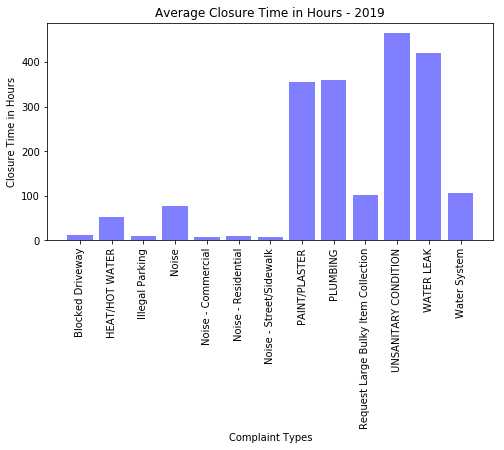

In [13]:
prepare_plot(nyc_311_df_resolution_time_2019, 'Complaint_Type',
                            "Average Closure Time in Hours - 2019", "Complaint Types", "Closure Time in Hours", 1, x_tick_rotation='vertical')

show_plot()

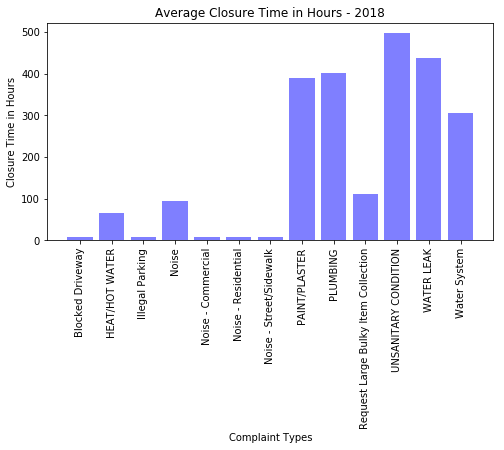

In [15]:
prepare_plot(nyc_311_df_resolution_time_2018, 'Complaint_Type',
                            "Average Closure Time in Hours - 2018", "Complaint Types", "Closure Time in Hours", 2, x_tick_rotation='vertical')

show_plot()